<a href="https://colab.research.google.com/github/RohitPrajapati111/Exoplanetary-identification/blob/main/exoplanetary_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#part 2

In [2]:
!pip install -U imbalanced-learn


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# loading of kepler exoplanet data
kepler_df = pd.read_csv('/content/cumulative_2025.10.03_22.27.36.csv', skiprows=53)

# Displaying of first data
print(kepler_df.head())
print(kepler_df.info())

      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \


#Data Prepocessing Steps

In [17]:
# for exoplanet being candidate value -> 1 else being false candidate -> 0
kepler_df['Exoplanet_Flag'] = kepler_df['koi_disposition'].apply(
    lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0
)

y = kepler_df['Exoplanet_Flag'] #Target variable y
print(f"Total number of entries: {len(y)}")
print("Class Distribution:\n", y.value_counts())
print(f"Percentage of 'Exoplanet being true' (1) class: {y.value_counts()[1] / len(y) * 100:.2f}%")

Total number of entries: 9564
Class Distribution:
 Exoplanet_Flag
0    4839
1    4725
Name: count, dtype: int64
Percentage of 'Exoplanet being true' (1) class: 49.40%


#feature selection
here we will drop colums with null value and select most prominent values

In [18]:
#Define Features as (X)
# Error columns and null value columns not taken.
features = [
    # False Positive Flags (Binary - Very predictive)
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    # Orbital and Transit Parameters
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    # Stellar Parameters
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag',
    # Stellar Coordinates
    'ra', 'dec'
]

X = kepler_df[features]
print(X)

      koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
0                 0              0              0              0    9.488036   
1                 0              0              0              0   54.418383   
2                 0              0              0              0   19.899140   
3                 0              1              0              0    1.736952   
4                 0              0              0              0    2.525592   
...             ...            ...            ...            ...         ...   
9559              0              1              1              0    0.527699   
9560              0              0              0              0    1.739849   
9561              0              0              1              0    0.681402   
9562              0              0              0              0  333.486169   
9563              0              0              1              1    4.856035   

      koi_time0bk  koi_impact  koi_dura

#handling of missing values

In [9]:
#handling missing value by putting median value of that column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)


scaler = StandardScaler()  #normalization to 0 and 1
X_scaled = scaler.fit_transform(X_imputed_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

#Train and Test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining data size: {len(X_train)} samples")
print(f"Test data size: {len(X_test)} samples")


Training data size: 6694 samples
Test data size: 2870 samples


--- Classification Metrics (Random Forest) ---
Accuracy: 0.9909
Precision: 0.9874
Recall: 0.9944
F1-Score: 0.9909
AUC-ROC: 0.9984

Model saved as random_forest_model.pkl.


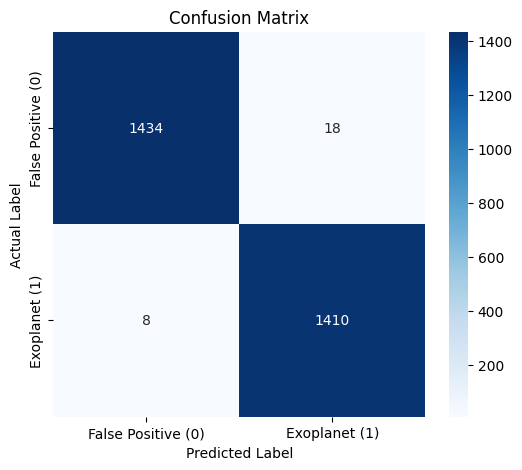

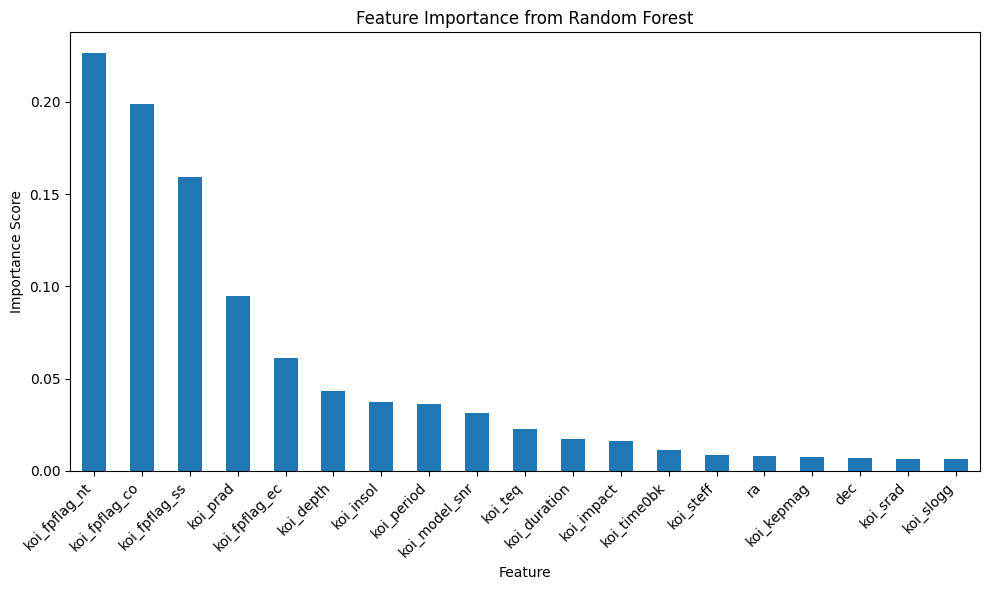

In [21]:
import joblib

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print("--- Classification Metrics (Random Forest) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False Positive (0)', 'Exoplanet (1)'],
            yticklabels=['False Positive (0)', 'Exoplanet (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Save model components for future deployment
joblib.dump(model, 'random_forest_model.pkl')
print("\nModel saved as random_forest_model.pkl.")

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# redefining enviornment to make ensure preprocessor are ok

# Define the 13 features used in the transferable model
KEPLER_FEATURES_13 = [
    'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad',
    'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad',
    'ra', 'dec', 'koi_kepmag'
]

# TESS feature map to match Kepler names
TESS_FEATURE_MAP = {
    'pl_orbper': 'koi_period', 'pl_tranmid': 'koi_time0bk', 'pl_trandurh': 'koi_duration',
    'pl_trandep': 'koi_depth', 'pl_rade': 'koi_prad', 'pl_eqt': 'koi_teq',
    'pl_insol': 'koi_insol', 'st_teff': 'koi_steff', 'st_logg': 'koi_slogg',
    'st_rad': 'koi_srad', 'st_tmag': 'koi_kepmag', 'ra': 'ra', 'dec': 'dec'
}
TESS_COLUMNS_RAW = list(TESS_FEATURE_MAP.keys())

# --- Re-run Kepler training setup to define imputer, scaler, and model_transfer ---
kepler_df = pd.read_csv('/content/cumulative_2025.10.03_22.27.36.csv', skiprows=53)
kepler_df['Exoplanet_Flag'] = kepler_df['koi_disposition'].apply(
    lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0
)
y_kepler = kepler_df['Exoplanet_Flag']
X_kepler = kepler_df[KEPLER_FEATURES_13]

imputer = SimpleImputer(strategy='median')
X_kepler_imputed = imputer.fit_transform(X_kepler)
scaler = StandardScaler()
scaler.fit(X_kepler_imputed) # Fit scaler only once on the training data

model_transfer = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model_transfer.fit(scaler.transform(X_kepler_imputed), y_kepler)



#tess data loading
tess_df = pd.read_csv('/content/TOI_2025.10.03_22.52.17.csv', skiprows=69)

# Select TESS raw columns and rename them according to feature map
X_tess = tess_df[TESS_COLUMNS_RAW].rename(columns=TESS_FEATURE_MAP)

# making tess dataframe exactly in same order as in keplers
X_tess = X_tess[KEPLER_FEATURES_13]

# Apply Imputation (using Kepler medians)
X_tess_imputed = imputer.transform(X_tess)

X_tess_scaled = scaler.transform(X_tess_imputed)
X_tess_scaled_df = pd.DataFrame(X_tess_scaled, columns=KEPLER_FEATURES_13)
print("\nTESS data preprocessing steps are completed.")


TESS data preprocessing steps are completed.


In [24]:
# making exoplanet predictions
tess_predictions = model_transfer.predict(X_tess_scaled_df)
tess_df['Exoplanet_Prediction'] = tess_predictions

# Define TESS Ground Truth (Y_tess)
# CP (Confirmed), PC (Candidate), KP (Known Planet) -> 1 (Exoplanet)
# FP (False Positive) -> 0 (Not Exoplanet)
tess_df['TESS_Flag'] = tess_df['tfopwg_disp'].apply(
    lambda x: 1 if x in ['CP', 'PC', 'KP'] else 0
)

y_tess_true = tess_df['TESS_Flag']
y_tess_pred = tess_df['Exoplanet_Prediction']

print("\n--- Model Performance on TESS Data---")
print(f"Accuracy: {accuracy_score(y_tess_true, y_tess_pred):.4f}")
print(f"Precision: {precision_score(y_tess_true, y_tess_pred):.4f}")
print(f"Recall: {recall_score(y_tess_true, y_tess_pred):.4f}")
print(f"F1-Score: {f1_score(y_tess_true, y_tess_pred):.4f}")

# Save the predictions to CSV
tess_predictions_output = tess_df[['toi', 'tfopwg_disp', 'TESS_Flag', 'Exoplanet_Prediction']]
tess_predictions_output.to_csv('tess_predictions.csv', index=False)
print("\nFinal TESS predictions are saved to 'tess_predictions.csv'")

# Display a sample of predictions
print("\nSample TESS Predictions vs. TESS Dispositions:")
print(tess_predictions_output.head(10))


--- Model Performance on TESS Data---
Accuracy: 0.6152
Precision: 0.8619
Recall: 0.5972
F1-Score: 0.7055

Final TESS predictions are saved to 'tess_predictions.csv'

Sample TESS Predictions vs. TESS Dispositions:
       toi tfopwg_disp  TESS_Flag  Exoplanet_Prediction
0  1000.01          FP          0                     0
1  1001.01          PC          1                     0
2  1002.01          FP          0                     0
3  1003.01          FP          0                     0
4  1004.01          FP          0                     0
5  1005.01          FP          0                     1
6  1006.01          FP          0                     0
7  1007.01          PC          1                     0
8  1008.01          FP          0                     0
9  1009.01          PC          1                     0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
